 ## Defining the problem and assembling a dataset

- Kaggle Twitter US Airline Sentiment
  - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

2023-02-19 21:21:01.545996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 21:21:03.565213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-19 21:21:03.565235: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-19 21:21:06.878493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
tweets = pd.read_csv('Tweets.csv', sep=',')
tweets = tweets[['text', 'airline_sentiment']]

tweets.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [4]:
TEST_SIZE = 0.1

(tweets_train, tweets_test, 
 sentiment_train, sentiment_test) = train_test_split(tweets['text'], tweets['airline_sentiment'], 
                                                     test_size=TEST_SIZE, stratify=tweets['airline_sentiment'],
                                                     shuffle=True, random_state=SEED)

In [5]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(tweets_train)

X_train, X_test = tfidf.transform(tweets_train).toarray(), tfidf.transform(tweets_test).toarray()

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(tweets['airline_sentiment'])

y_train = np_utils.to_categorical(label_encoder.transform(sentiment_train))
y_test = np_utils.to_categorical(label_encoder.transform(sentiment_test))

In [7]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [8]:
counts = tweets.groupby(['airline_sentiment']).count()
counts.reset_index(inplace=True)

counts

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


In [9]:
baseline = counts[counts['airline_sentiment']=='negative']['text'].values[0] / counts['text'].sum()

baseline

0.6269125683060109

In [10]:
balanced_accuracy_score(y_train.argmax(axis=1), np.zeros(len(y_train)))

0.3333333333333333

In [11]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                                     dropout=np.nan, input_dimension=2, output_dimension=1,
                                     optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                                     name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [12]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [13]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

2023-02-19 21:21:11.394653: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-19 21:21:11.394681: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-19 21:21:11.394703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snottingham): /proc/driver/nvidia/version does not exist
2023-02-19 21:21:11.394944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
slp_model = deep_neural_network(hidden_layers=0, 
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 15003     
                                                                 
Total params: 15,003
Trainable params: 15,003
Non-trainable params: 0
_________________________________________________________________


In [15]:
batch_size = 512
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [16]:
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 0.5317352220103514, 1: 1.5748285599031868, 2: 2.064516129032258}

In [17]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=500, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [18]:
print('Accuracy (Validation): {:.2f} (baseline=0.63)'.format(trained_slp_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.80 (baseline=0.63)
Precision (Validation): 0.83
Recall (Validation): 0.77
AUC (Validation): 0.92


In [19]:
preds = trained_slp_model['model'].predict(X_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.33)'.format(balanced_accuracy_score(y_val.argmax(axis=1), preds)))

Balanced Accuracy (Validation): 0.78 (baseline = 0.33)


In [20]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

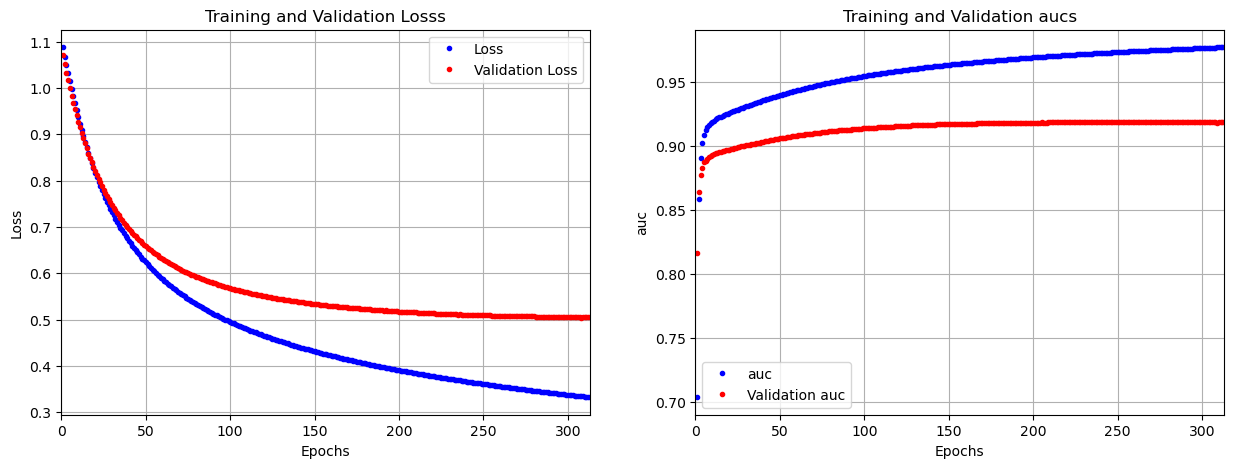

In [34]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [22]:
mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [23]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

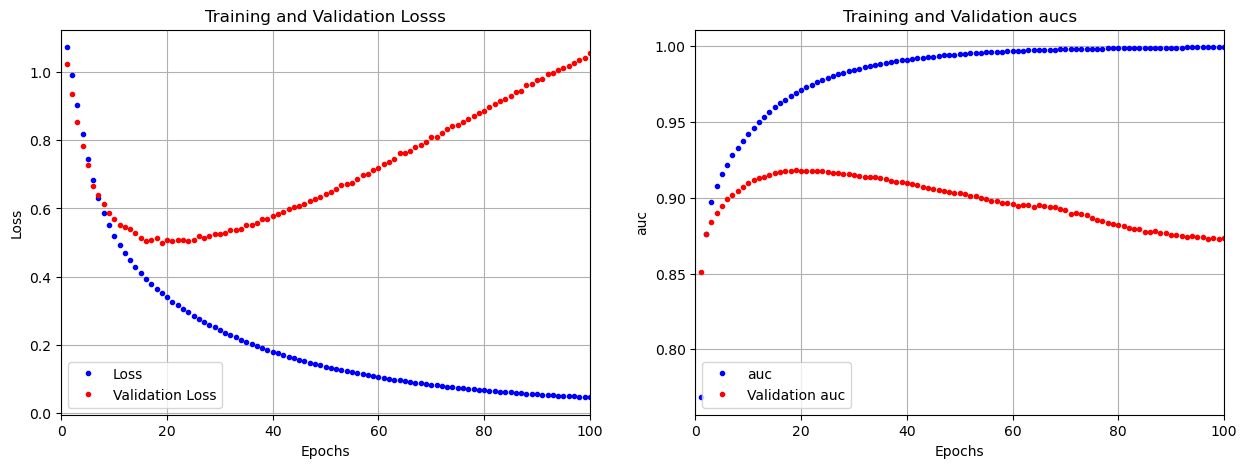

In [33]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [25]:
print('Accuracy (Validation): {:.2f} (baseline=0.63)'.format(trained_mlp_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.78 (baseline=0.63)
Precision (Validation): 0.78
Recall (Validation): 0.78
AUC (Validation): 0.87


In [26]:
preds = trained_mlp_model['model'].predict(X_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline=0.33)'.format(balanced_accuracy_score(y_val.argmax(axis=1), preds)))

Balanced Accuracy (Validation): 0.73 (baseline=0.33)


 ## Regularizing your model and tuning your hyperparameters

In [27]:
# Compute Balanced Accuracy Score for Softmax One-Hot Encoded Output
def compute_balanced_accuracy_score(y, preds) :
    return balanced_accuracy_score(y.argmax(axis=1), preds.argmax(axis=1))

# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [28]:
# Grid Search CV
def grid_search_cv(X, y, class_weights, 
                   space, cv, 
                   optimizer, loss, metrics, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y.argmax(axis=1)) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=optimizer, loss=loss, 
                                        metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                class_weights,
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate,:]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate,:], verbose=0)[1:]
            for key, value in addon_metrics.items() :
                preds = trained['model'].predict(X[validate,:], verbose=0)
                evaluations.append( value(y[validate,:], preds) )
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [29]:
addon_metrics = {'balanced_accuracy': compute_balanced_accuracy_score}

orders = {
    0: 'categorical_accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
    4: 'balanced_accuracy'
}

In [30]:
KFOLDS = 5

In [31]:
params = {
    'hidden_layers': [1, 2, 3, 4, 5],
    'neurons': [32, 64],
    'activation': ['relu'],
    'dropout': [0.25, 0.5],
    'batch_size': [512]
}

stats = grid_search_cv(X_train, y_train,  
                       class_weights=CLASS_WEIGHTS,
                       space=params, cv=KFOLDS, 
                       optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       addon_metrics=addon_metrics, order=orders)

In [35]:
stats.sort_values(by=['auc'], ascending=False).head(10)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc,balanced_accuracy
7,2,64,relu,0.50,512,16.2,0.522279,0.795594,0.814859,0.769382,0.909787,0.756999
1,1,32,relu,0.50,512,39.4,0.524633,0.790215,0.814959,0.758708,0.909138,0.753529
5,2,32,relu,0.50,512,22.0,0.527027,0.794654,0.816257,0.768442,0.908868,0.753381
3,1,64,relu,0.50,512,28.8,0.527083,0.788763,0.814721,0.755635,0.908698,0.753119
6,2,64,relu,0.25,512,14.2,0.520064,0.794740,0.814818,0.769637,0.908550,0.752430
2,1,64,relu,0.25,512,28.8,0.526452,0.786885,0.811644,0.757513,0.907764,0.749629
0,1,32,relu,0.25,512,35.2,0.529332,0.787226,0.810298,0.754354,0.907438,0.752007
10,3,64,relu,0.25,512,11.2,0.527767,0.795935,0.817984,0.768783,0.906497,0.746741
8,3,32,relu,0.25,512,14.4,0.532830,0.795936,0.816184,0.769467,0.906376,0.749372
4,2,32,relu,0.25,512,18.8,0.532666,0.790641,0.810375,0.765539,0.906111,0.754465


In [37]:
opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=32,
                                dropout=0.5, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Narrow_Shallow_Network')

opt_model.summary()

Model: "Narrow_Shallow_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_403 (Dense)           (None, 32)                160032    
                                                                 
 dropout_300 (Dropout)       (None, 32)                0         
                                                                 
 dense_404 (Dense)           (None, 3)                 99        
                                                                 
Total params: 160,131
Trainable params: 160,131
Non-trainable params: 0
_________________________________________________________________


In [38]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

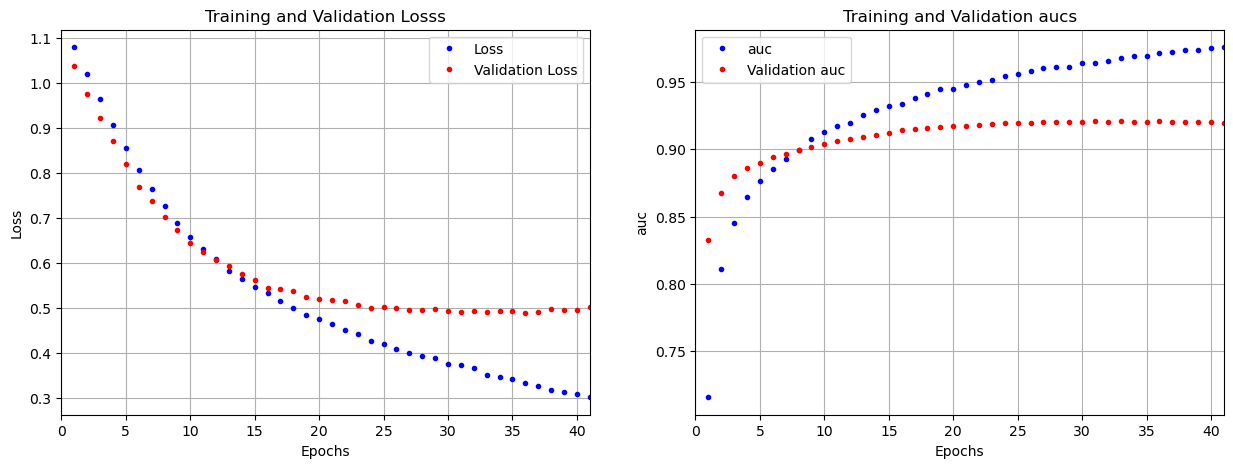

In [39]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [40]:
print('Accuracy (Validation): {:.2f} (baseline=0.63)'.format(trained_opt_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.81 (baseline=0.63)
Precision (Validation): 0.82
Recall (Validation): 0.78
AUC (Validation): 0.92


In [41]:
preds = trained_opt_model['model'].predict(X_val, verbose=0).argmax(axis=1)

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.33)'.format(balanced_accuracy_score(y_val.argmax(axis=1), preds)))

Balanced Accuracy (Validation): 0.78 (baseline = 0.33)


In [42]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline=0.63)'.format(accuracy_score(y_test.argmax(axis=1), 
                                                                      preds.argmax(axis=1))))
print('Precision (Test): {:.2f}'.format(precision_score(y_test.argmax(axis=1), 
                                                        preds.argmax(axis=1),
                                                        average='macro')))
print('Recall (Test): {:.2f}'.format(recall_score(y_test.argmax(axis=1), 
                                                  preds.argmax(axis=1),
                                                  average='macro')))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, 
                                                preds,

                                                multi_class='ovo',
                                                average='macro')))

Accuracy (Test): 0.79 (baseline=0.63)
Precision (Test): 0.73
Recall (Test): 0.75
AUC (Test): 0.91


In [43]:
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.33)'.format(balanced_accuracy_score(y_test.argmax(axis=1), preds.argmax(axis=1))))

Balanced Accuracy (Validation): 0.75 (baseline = 0.33)


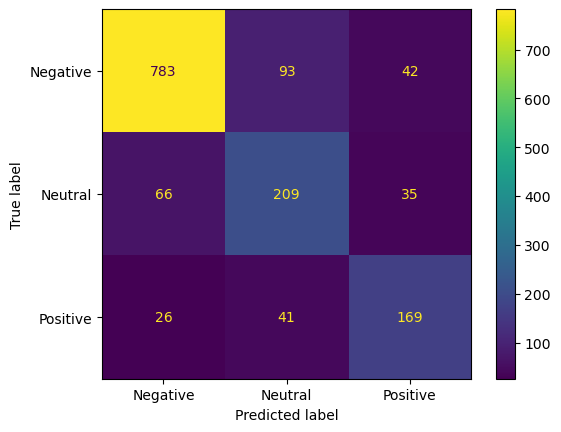

In [44]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)),
                               display_labels=['Negative', 'Neutral', 'Positive'])
_ = disp.plot()